In [49]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']

## 自行实现PCA算法

In [50]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class MyPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components_ = n_components

    def __sort_eig_desc(self, eig_vals, eig_vects):
        indices = np.argsort(-eig_vals)
        return eig_vals[indices], eig_vects[:, indices]

    def get_covariance(self):
        return self.cov_

    def __zero_centered(self, X):
        mean = np.mean(X, axis=0)
        return X - mean, mean

    def fit(self, X, y=None):
        X, self.mean_ = self.__zero_centered(X)
        # 由于已经中心化，直接使用矩阵乘法即可求出协方差矩阵
        self.cov_ = X.T @ X / (X.shape[0] - 1)
        self.eig_vals_, self.eig_vects_ = self.__sort_eig_desc(
            *np.linalg.eig(self.cov_)
        )
        self.explained_variance_ = self.eig_vals_[: self.n_components_]
        self.explained_variance_ratio_ = self.explained_variance_ / np.sum(
            self.eig_vals_
        )
        self.components_ = self.eig_vects_[:, : self.n_components_].T
        return self

    def transform(self, X):
        X = X - self.mean_
        n_eig_vect = self.eig_vects_[:, : self.n_components_]
        return X @ n_eig_vect + self.mean_[: self.n_components_]

### 使用自行实现的 PCA 算法对数据进行降维

In [51]:
from sklearn.datasets import load_iris

iris_data = load_iris()
X_iris, y_iris = iris_data.data, iris_data.target

my_pca = MyPCA(n_components=2)
my_reduced_X = my_pca.fit_transform(X_iris)


def beautify_float_list(lst):
    return ", ".join(map(lambda x: "%.2f" % x, lst))


print("协方差矩阵\n", my_pca.get_covariance())
print("降维后主成分的方差值", beautify_float_list(my_pca.explained_variance_))
print(
    "降维后主成分的方差值占总方差的比例",
    beautify_float_list(my_pca.explained_variance_ratio_),
)
print("降维后最大方差的成分\n", my_pca.components_)
print("降维后主成分的个数", my_pca.n_components_)


协方差矩阵
 [[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]
降维后主成分的方差值 4.23, 0.24
降维后主成分的方差值占总方差的比例 0.92, 0.05
降维后最大方差的成分
 [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [-0.65658877 -0.73016143  0.17337266  0.07548102]]
降维后主成分的个数 2


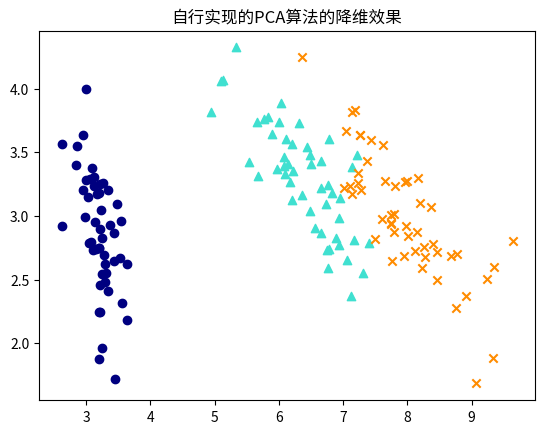

In [52]:
my_reduced_X_y = np.column_stack((my_reduced_X, y_iris))
colors = ["navy", "turquoise", "darkorange"]
markers = ["o", "^", "x"]

for i in range(len(iris_data.target_names)):
    plt.scatter(
        my_reduced_X[my_reduced_X_y[:, 2] == i, 0],
        my_reduced_X[my_reduced_X_y[:, 2] == i, 1],
        c=colors[i],
        marker=markers[i],
    )
plt.title("自行实现的PCA算法的降维效果")
plt.savefig("figures/my_pca.png", dpi=300)
plt.show()


## 对鸢尾花数据集进行降维

In [53]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

iris_data = load_iris()
X_iris, y_iris = iris_data.data, iris_data.target
sk_pca = PCA(n_components=2)
reduced_X = sk_pca.fit_transform(X_iris)


print("协方差矩阵\n", sk_pca.get_covariance())
print("降维后主成分的方差值", beautify_float_list(sk_pca.explained_variance_))
print(
    "降维后主成分的方差值占总方差的比例",
    beautify_float_list(sk_pca.explained_variance_ratio_),
)
print("降维后最大方差的成分\n", sk_pca.components_)
print("降维后主成分的个数", sk_pca.n_components_)

协方差矩阵
 [[ 0.67918961 -0.03571514  1.2714061   0.53137208]
 [-0.03571514  0.18303922 -0.32672469 -0.13706322]
 [ 1.2714061  -0.32672469  3.12237957  1.28464626]
 [ 0.53137208 -0.13706322  1.28464626  0.58834865]]
降维后主成分的方差值 4.23, 0.24
降维后主成分的方差值占总方差的比例 0.92, 0.05
降维后最大方差的成分
 [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]
降维后主成分的个数 2


### 绘制分类结果图

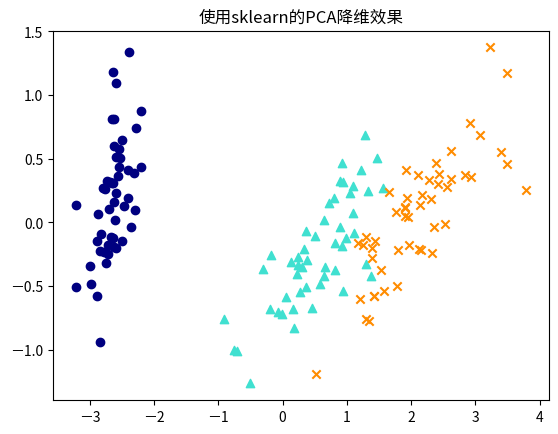

In [54]:
reduced_X_y = np.column_stack((reduced_X, y_iris))
colors = ['navy', 'turquoise', 'darkorange']
markers = ['o', '^', 'x']

for i in range(len(iris_data.target_names)):
    plt.scatter(
        reduced_X[reduced_X_y[:, 2] == i, 0],
        reduced_X[reduced_X_y[:, 2] == i, 1],
        c=colors[i],
        marker=markers[i],
    )
plt.title("使用sklearn的PCA降维效果")
plt.savefig("figures/sklearn_pca.png", dpi=300)
plt.show()

## 手写数据集的PCA算法

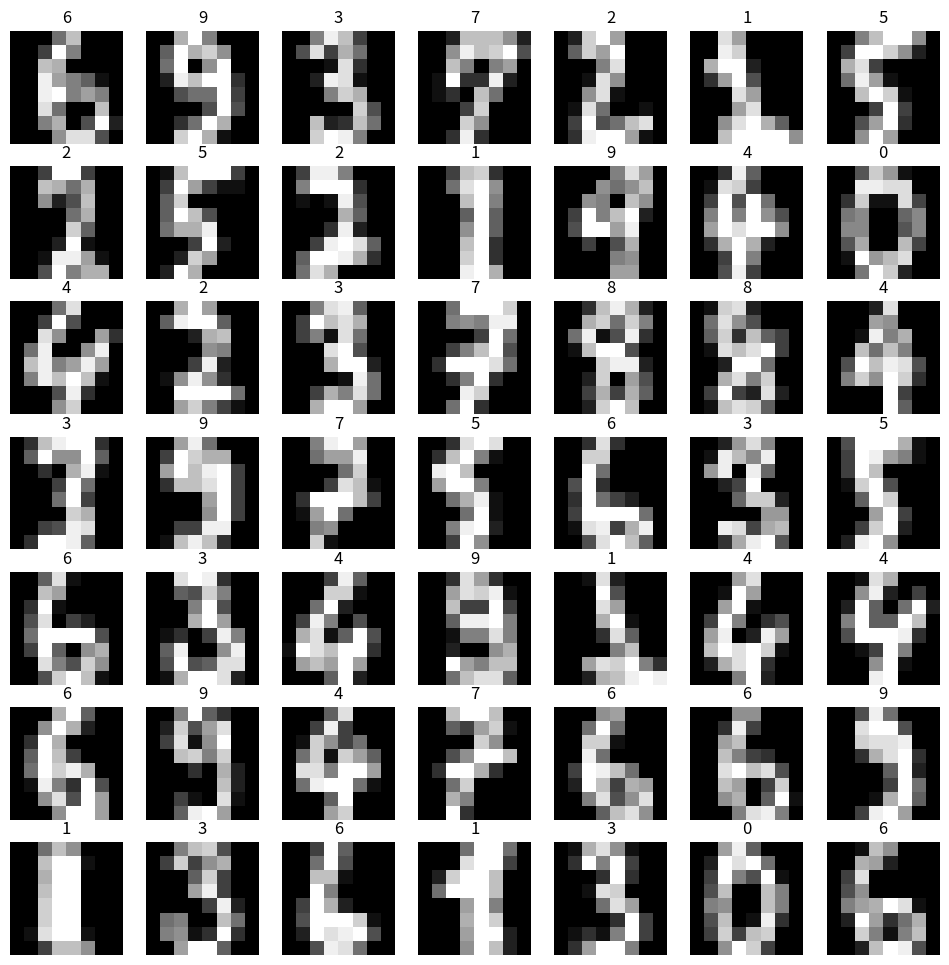

In [55]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.pipeline import make_pipeline

digits = load_digits()
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=42
)

samples = X_d_test[:49]
samples_actual_labels = y_d_test[:49]
plt.figure(figsize=(12, 12))
for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.axis("off")
    plt.imshow(samples[i].reshape(8, 8), cmap="gray")
    title = str(samples_actual_labels[i])
    plt.title(title)
plt.axis("off")
plt.savefig("figures/digits_samples.png", dpi=300)
plt.show()

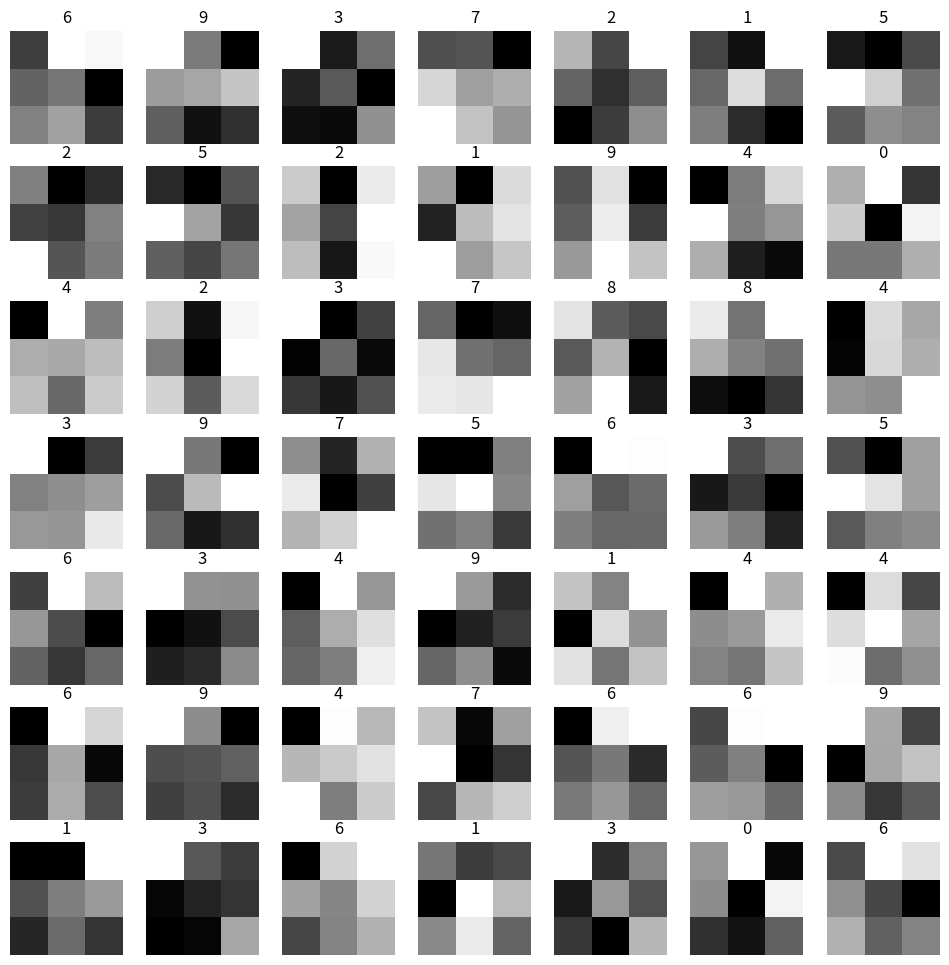

In [56]:
samples_pca = PCA(n_components=9).fit_transform(X_d_test)[:49]

plt.figure(figsize=(12, 12))
for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.axis("off")
    plt.imshow(samples_pca[i].reshape(3, 3), cmap="gray")
    title = str(samples_actual_labels[i])
    plt.title(title)
plt.axis("off")
plt.savefig("figures/pca_digits.png", dpi=300)
plt.show()


In [62]:
svc = make_pipeline(StandardScaler(), SVC()).fit(X_d_train, y_d_train)

print("The Accuracy of SVC: ", svc.score(X_d_test, y_d_test))
print(
    "Classification Report of SVC\n",
    classification_report(
        y_d_test, svc.predict(X_d_test), target_names=digits.target_names.astype(str)
    ),
)


The Accuracy of SVC:  0.9805555555555555
Classification Report of SVC
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       0.96      1.00      0.98        46
           5       0.96      0.98      0.97        47
           6       0.97      1.00      0.99        35
           7       1.00      0.94      0.97        34
           8       0.97      0.97      0.97        30
           9       0.97      0.95      0.96        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



In [58]:
svc_pca = make_pipeline(StandardScaler(), PCA(n_components=10, whiten=True), SVC()).fit(
    X_d_train, y_d_train
)

print("The Accuracy of SVC with PCA: ", svc_pca.score(X_d_test, y_d_test))
print(
    "Classification Report of SVC with PCA\n",
    classification_report(
        y_d_test,
        svc_pca.predict(X_d_test),
        target_names=digits.target_names.astype(str),
    ),
)


The Accuracy of SVC with PCA:  0.9361111111111111
Classification Report of SVC with PCA
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.97      1.00      0.98        28
           2       0.94      1.00      0.97        33
           3       0.90      0.79      0.84        34
           4       1.00      1.00      1.00        46
           5       0.96      0.96      0.96        47
           6       1.00      0.97      0.99        35
           7       0.97      0.94      0.96        34
           8       0.86      0.80      0.83        30
           9       0.80      0.88      0.83        40

    accuracy                           0.94       360
   macro avg       0.94      0.93      0.93       360
weighted avg       0.94      0.94      0.94       360



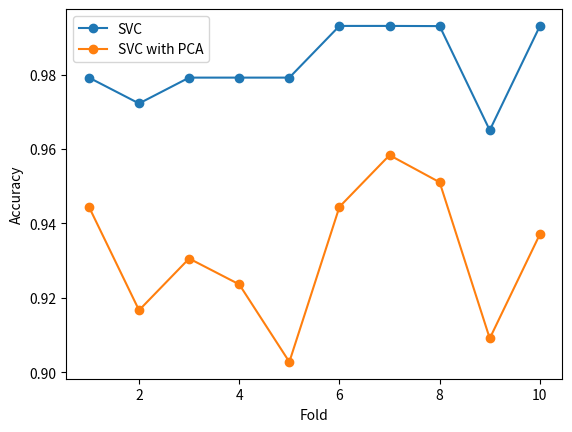

In [59]:
from sklearn.model_selection import cross_val_score

def draw_score_line(estimator, X, y):
    scores = cross_val_score(estimator, X, y, cv=10)
    plt.plot(range(1, 11), scores, marker="o")
    
draw_score_line(svc, X_d_train, y_d_train)
draw_score_line(svc_pca, X_d_train, y_d_train)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend(["SVC", "SVC with PCA"])
plt.savefig("figures/pca_compare.png", dpi=300)
plt.show()

## 我国经济指标的降维处理

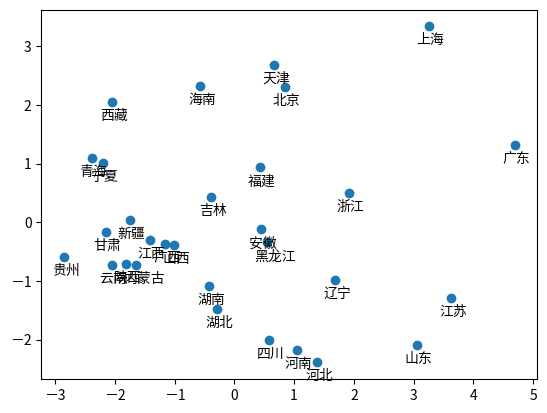

In [63]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

economy_data = pd.read_excel("economy_data.xlsx", index_col=0)
economy_data_pca = make_pipeline(StandardScaler(), PCA(n_components=2)).fit_transform(
    economy_data
)

plt.scatter(economy_data_pca[:, 0], economy_data_pca[:, 1])
for city in economy_data.index:
    plt.text(
        economy_data_pca[economy_data.index == city, 0] - 0.2,
        economy_data_pca[economy_data.index == city, 1] - 0.3,
        city,
    )

plt.savefig("figures/economy_pca.png", dpi=300)
plt.show()